Voy a hacer una función 'Prepare' de data preprocessing que procesa el train, val y test.
La función hará:
-

Abrirá las imágenes en TF
Aplicar reescalado y normalización a las imágenes de todos los conjuntos de datos.
Podrá mezclar el conjunto.
Convertirá todo el conjunto de entrenamiento en batches de len determinada. 
Si el flag del aumento está en TRUE, aplicará nuestra función data augmentation al batch. 
Por último, utiliza Dataset.prefetch para solapar el entrenamiento de tu modelo en la GPU con el procesamiento de los datos.

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.colors as colors
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
def cargar(imagen,label):
    image_bytes = tf.io.read_file(imagen)
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    return image, label

In [3]:
def normalizar(imagen,label):
    image = tf.cast(imagen, tf.float32)
    image /= 255.
    return image, label

In [4]:
def resize(imagen,label):
    imagen = tf.image.resize(imagen, (128,128))
    return imagen,label

In [5]:
# Define tu función Python
def mi_funcion_python(img, label):

    img = img.numpy().reshape(128,128,3)
    
    # Creo el número aleatorio
    numero_aleatorio = random.uniform(0, 0.8)
    
    # Ahora controlo qué aumento se hace en  función de ese número
    if numero_aleatorio < 0.1:

        # 0 means flipping around the x-axis
        # 1 means flipping around y-axis
        # -1 means flipping around both axes.
        aleat = random.randint(-1, 1)
        augmented = cv2.flip(img, aleat)

    elif numero_aleatorio < 0.2:

        aleat = random.randint(0,360)
        alto, ancho = img.shape[:2]
        centro = (ancho // 2, alto // 2)
        matriz_rotacion = cv2.getRotationMatrix2D(centro, aleat, 1.0)
        augmented = cv2.warpAffine(img, matriz_rotacion, (ancho, alto), flags=cv2.INTER_LINEAR)

    elif numero_aleatorio < 0.3:

        aleat = random.randint(0,3)
        aleat = aleat if aleat % 2 != 0 else aleat + 1
        augmented=np.copy(img)
        augmented[:, :, 0] = cv2.GaussianBlur(img[:, :, 0], (aleat,aleat), 0)  # Canal R
        augmented[:, :, 1] = cv2.GaussianBlur(img[:, :, 1], (aleat,aleat), 0)  # Canal G
        augmented[:, :, 2] = cv2.GaussianBlur(img[:, :, 2], (aleat,aleat), 0)  # Canal B

    elif numero_aleatorio < 0.4:

        a = random.randint(0,2)
        b = random.randint(0,2)
        kernel = np.ones((a,b),np.uint8)
        augmented = cv2.dilate(img,kernel,iterations = 1)

    elif numero_aleatorio < 0.5:

        a = random.uniform(5,7)
        kernel = np.array([
                          [0, -1, 0],
                          [-1, a, -1],
                          [0, -1, 0]
                                    ])
        augmented = cv2.filter2D(img, -1, kernel)

    elif numero_aleatorio < 0.6:

        a = random.uniform(-0.3,0.3)
        b = random.uniform(-0.3,0.3)
        alto, ancho = img.shape[:2]
        M = np.float32([[1, a, 0],   # No hay cambio en x, un cizallamiento de 0.5 en y
                       [b, 1, 0]])
        augmented = cv2.warpAffine(img, M, (ancho, alto))

    elif numero_aleatorio < 0.7:

        a = random.randint(-35,35)
        b = random.randint(-35,35)
        M_traslacion = np.float32 ([[1, 0, a],
                                   [0, 1, b]])
        alto, ancho = img.shape[:2]
        augmented = cv2.warpAffine(img, M_traslacion, (ancho, alto))

    elif numero_aleatorio <= 0.8:

        a = random.uniform(0,0.1)
        ruido = np.random.normal(0, a, img.shape).astype(np.float32)
        augmented = cv2.add(img, ruido)


    return augmented, label

In [6]:
# Define tu función Python
def mi_funcion_python1(img, label):

     img = img.numpy().reshape(128,128,3)
     # 0 means flipping around the x-axis
     # 1 means flipping around y-axis
     # -1 means flipping around both axes.
     aleat = random.randint(-1, 1)
     augmented1 = cv2.flip(img, aleat)
     aleat = random.randint(0,360)
     alto, ancho = img.shape[:2]
     centro = (ancho // 2, alto // 2)
     matriz_rotacion = cv2.getRotationMatrix2D(centro, aleat, 1.0)
     augmented2 = cv2.warpAffine(img, matriz_rotacion, (ancho, alto), flags=cv2.INTER_LINEAR)
     aleat = random.randint(0,3)
     aleat = aleat if aleat % 2 != 0 else aleat + 1
     augmented3=np.copy(img)
     augmented3[:, :, 0] = cv2.GaussianBlur(img[:, :, 0], (aleat,aleat), 0)  # Canal R
     augmented3[:, :, 1] = cv2.GaussianBlur(img[:, :, 1], (aleat,aleat), 0)  # Canal G
     augmented3[:, :, 2] = cv2.GaussianBlur(img[:, :, 2], (aleat,aleat), 0)  # Canal B
     a = random.randint(0,2)
     b = random.randint(0,2)
     kernel = np.ones((a,b),np.uint8)
     augmented4 = cv2.dilate(img,kernel,iterations = 1)
     a = random.uniform(5,7)
     kernel = np.array([
                       [0, -1, 0],
                       [-1, a, -1],
                       [0, -1, 0]
                                 ])
     augmented5 = cv2.filter2D(img, -1, kernel)
     a = random.uniform(-0.3,0.3)
     b = random.uniform(-0.3,0.3)
     alto, ancho = img.shape[:2]
     M = np.float32([[1, a, 0],   # No hay cambio en x, un cizallamiento de 0.5 en y
                    [b, 1, 0]])
     augmented6 = cv2.warpAffine(img, M, (ancho, alto))
     a = random.randint(-35,35)
     b = random.randint(-35,35)
     M_traslacion = np.float32 ([[1, 0, a],
                                [0, 1, b]])
     alto, ancho = img.shape[:2]
     augmented7 = cv2.warpAffine(img, M_traslacion, (ancho, alto))
     a = random.uniform(0,0.1)
     ruido = np.random.normal(0, a, img.shape).astype(np.float32)
     augmented8 = cv2.add(img, ruido)

     lista = [img, augmented1, augmented2, augmented3, augmented4, augmented5, augmented6, augmented7, augmented8]
     return lista, label

In [7]:
 # Envuelve tu función Python con tf.py_function
@tf.function
def aumento(arg1, arg2):
    return tf.py_function(mi_funcion_python1, [arg1, arg2], [tf.float32, tf.int32])

In [8]:
def prepare(ruta, shuffle=False, train=False):
    # 1. Abro los datos con Pandas
    data = pd.read_csv(ruta, sep = ';', index_col='#JID')
    
    # Guardo en una lista los paths relativos y sus clases, codificadas a numeros
    file_paths = data['fpCid'].values.tolist()
    mappings = {'Spirals': 0, 'S0s': 1, 'Ellipticals': 2}
    data['Clase'] = data['Clase'].map(mappings)
    labels = data['Clase'].values.tolist()
    BUFFER = 1064
    LOTE = 512
    # TODO ESTO OCURRIRÁ CUANDO EL MODELO LLAME A TRAIN_DS
    a = [file_paths[0]]
    b = [labels[0]]
    # Crear el dataset a partir de las listas. Ahora tengo un dataset, pero con la diferencia de que mi X_train es un vector de paths.
    # Esto me sirve para hacer operaciones con los datos sin tener que manejar tensores. Más rápido.
    train_ds = tf.data.Dataset.from_tensor_slices((a,b))
    # Ahora quiero barajarlos
    if shuffle:
        train_ds = train_ds.shuffle(BUFFER)
    # Ahora quiero cargar las imágenes en tensorflow. Aplico la función cargar.
    train_ds = train_ds.map(cargar, tf.data.experimental.AUTOTUNE)
    # Mormalizo los píxeles
    train_ds = train_ds.map(normalizar, tf.data.experimental.AUTOTUNE)
    # Hago un resize para equiparar todas las imágenes. Las dimensiones provienen de la media ponderada de toda la muestra.
    train_ds = train_ds.map(resize, tf.data.experimental.AUTOTUNE)
    print(train_ds)
    if train:
        
        # Aplica la función a los datos
        train_ds = train_ds.map(aumento)
        
        # Asigna formas fijas a los tensores de salida
        train_ds = train_ds.map(lambda x, y: (tf.ensure_shape(x, [128,128,3]), tf.ensure_shape(y, [])))

     # Guardo en cache en vez del disco para agilizar el proceso
    print(train_ds)
    train_ds = train_ds.cache()
    # Los guardo en lotes
    train_ds = train_ds.batch(LOTE)
    train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
    # AQUÍ DEBERÍA IR EL DATA AUGMENTATION. VEAMOS

    print(train_ds)
    
    return train_ds

In [41]:
train_ds = prepare('..\\..\\Data\\Dataset\\Train.csv', shuffle=True, train=False)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<_ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


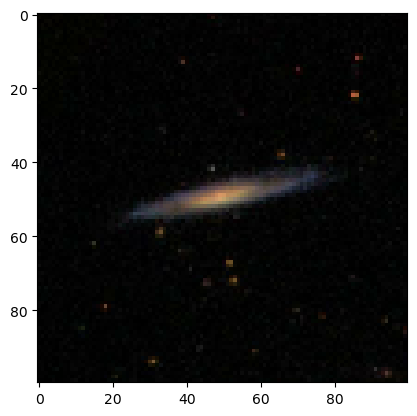

In [42]:
for a,b in train_ds.take(1):
    lista, label = aumento(a,b)
plt.figure()
plt.imshow(a[0,:,:,:].numpy())
lista = lista.numpy()
lista1 = ['Original', 'Flip', 'Rotación', 'Gaussian Blur', 'Dilatación', 'Sharpen', 'Shear', 'Traslación', 'Ruido']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 4 is out of bounds for axis 1 with size 4

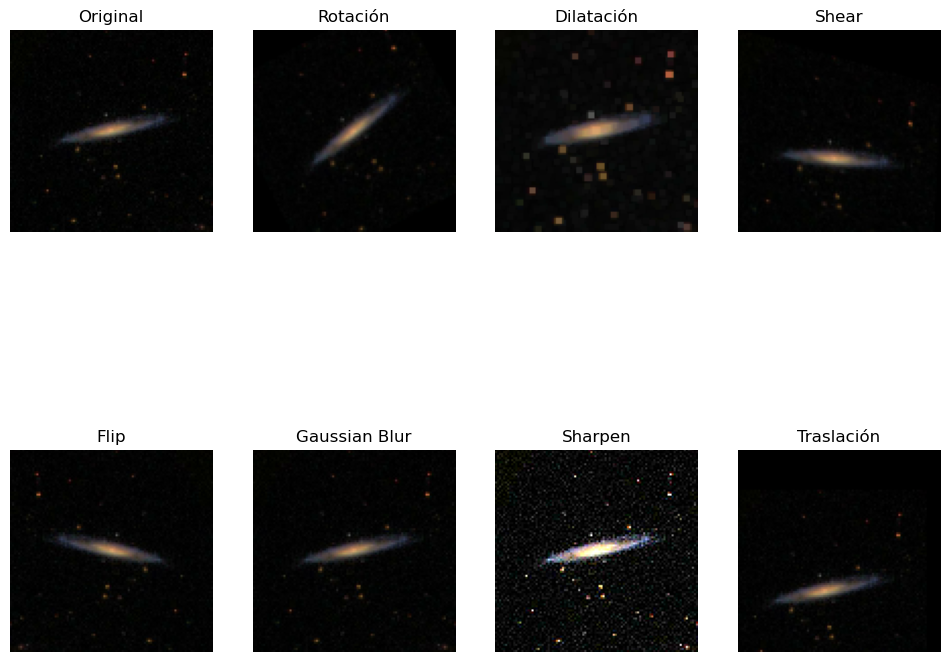

In [45]:
# Calcula el número de imágenes y ajusta el número de filas y columnas necesarias
num_imagenes = len(lista)
num_filas = 2  # Se ajusta para acomodar las 17 imágenes
num_columnas = (num_imagenes-1 + num_filas - 1) // num_filas

# Crea una figura y subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, 10))

# Itera sobre las rutas de archivo, los títulos y los subplots para mostrar cada imagen en su respectivo subplot
for i, (ruta, titulo) in enumerate(zip(lista, lista1)):
    # Calcula la posición del subplot actual
    fila = i % num_filas
    columna = i // num_filas
    
    # Carga la imagen desde la ruta de archivo
    # imagen = plt.imread(ruta)
    
    # Muestra la imagen en el subplot correspondiente
    axs[fila, columna].imshow(ruta)
    axs[fila, columna].set_title(titulo)
    axs[fila, columna].axis('off')

# Ajusta el diseño de los subplots
plt.tight_layout()
plt.savefig("Clases.jpg")
# Muestra la figura
plt.show()

In [ ]:
val_ds = prepare('..\\..\\Data\\Dataset\\Val1.csv', shuffle=False, train=False)

In [145]:
# Creamos un modelo ancho
w_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(4024, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2012, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1286, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(503, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(251, activation = 'relu'),
    tf.keras.layers.Dense(3)
])

# Vemos el número de parámetros
w_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)                 │ (None, 30000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 4024)                │     120,724,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 4024)                │          16,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 2012)                │       8,098,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 2012)                │           8,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1006)                │       2,025,078 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 1006)                │           4,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 503)                 │         506,521 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 503)                 │           2,012 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 251)                 │         126,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 3)                   │             756 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,511,363 (501.68 MB)

 Trainable params: 131,496,273 (501.62 MB)

 Non-trainable params: 15,090 (58.95 KB)

In [146]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1280,
    decay_rate=0.96,
    staircase=True)

In [147]:
w_model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [148]:
# tensorboard_callback = TensorBoard(log_dir="./logs")
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [149]:
history = w_model.fit(train_ds, epochs=128, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3941 - loss: 0.9957 - val_accuracy: 0.3089 - val_loss: 1.1000
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6391 - loss: 0.8895 - val_accuracy: 0.3078 - val_loss: 1.1002
Epoch 3/100
 3/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8585 - loss: 0.7093

KeyboardInterrupt: 

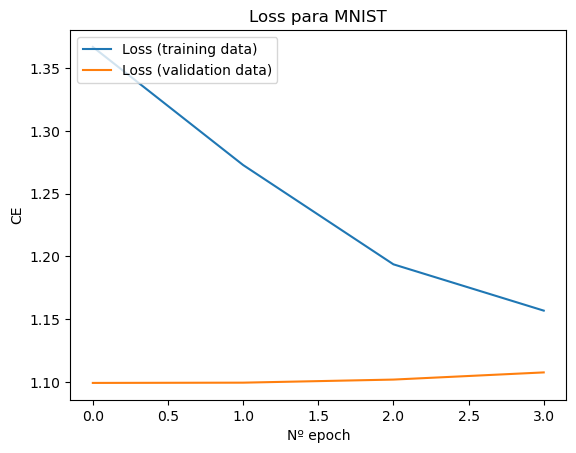

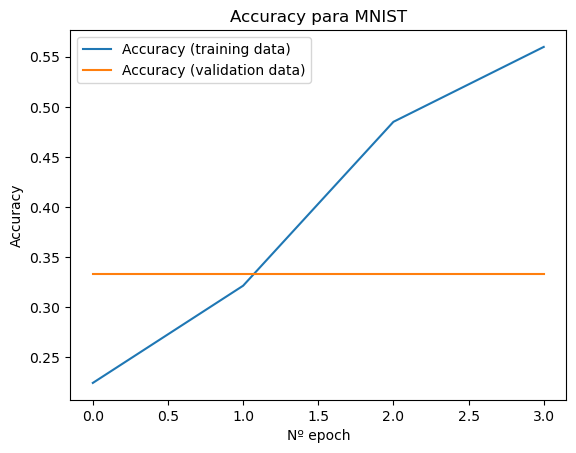

In [132]:
plt.figure()
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss para MNIST')
plt.ylabel('CE')
plt.xlabel('Nº epoch')
plt.legend(loc="upper left")
plt.show()

# Plot history: Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy para MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Nº epoch')
plt.legend(loc="upper left")
plt.show()

In [16]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

In [17]:
# # Gráfica de loss
# plt.plot(loss, label='Train Loss')
# plt.plot(val_loss, label='Val Loss')
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Gráfica de accuracy
# plt.plot(accuracy, label='Train Accuracy')
# plt.plot(val_accuracy, label='Val Accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()


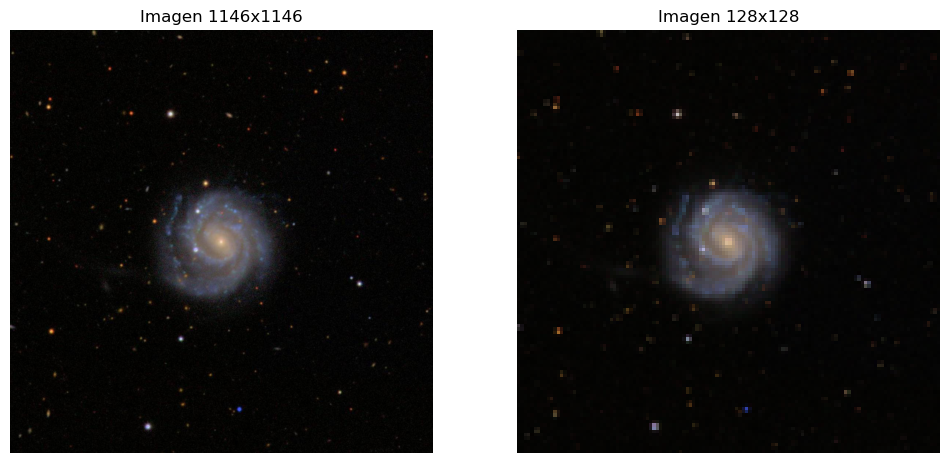

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

# Función de ejemplo para redimensionar la imagen
def resize(image, label, new_size=(128,128)):
    """
    Redimensiona la imagen a un tamaño nuevo.

    :param image: PIL.Image, imagen a redimensionar
    :param label: str, etiqueta de la imagen
    :param new_size: tuple, tamaño nuevo (ancho, alto)
    :return: PIL.Image, imagen redimensionada
    """
    return image.resize(new_size), label

# Nombre de la imagen
image_path = '..//..//Data//Images//fpC-002826-40-6-0273-0013.jpg'  # Reemplaza con la ruta de tu imagen si está en otro directorio

# Cargar la imagen original
original_image = Image.open(image_path)
label = "Imagen 1146x1146"

# Redimensionar la imagen
resized_image, resized_label = resize(original_image, label)

# Mostrar la imagen original y la redimensionada
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Mostrar la imagen original
axes[0].imshow(original_image)
axes[0].set_title(label)
axes[0].axis('off')

# Mostrar la imagen redimensionada
axes[1].imshow(resized_image)
axes[1].set_title('Imagen 128x128')
axes[1].axis('off')

plt.show()


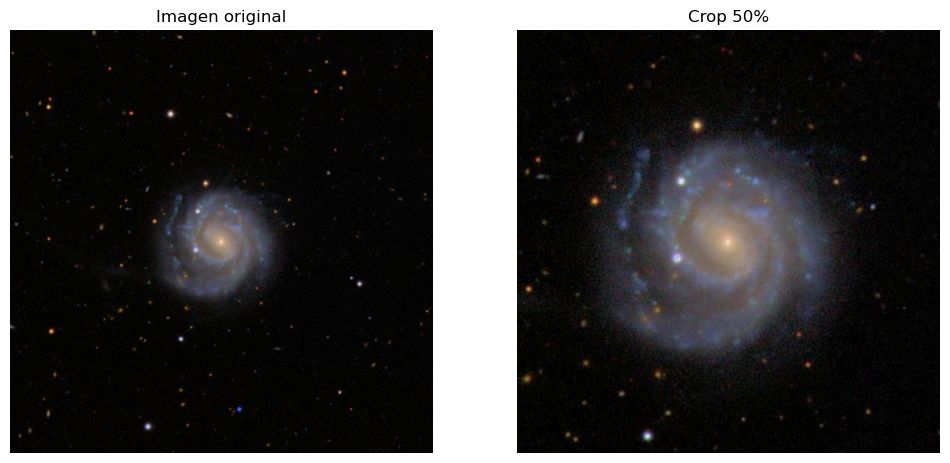

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

# Función para recortar la imagen al 50% centrado
def crop_center(image, label, crop_fraction=0.5):
    """
    Recorta la imagen centrada al porcentaje especificado.

    :param image: PIL.Image, imagen a recortar
    :param label: str, etiqueta de la imagen
    :param crop_fraction: float, fracción para recortar (por defecto 0.5 para 50%)
    :return: PIL.Image, imagen recortada
    """
    width, height = image.size
    new_width = int(width * crop_fraction)
    new_height = int(height * crop_fraction)

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2

    return image.crop((left, top, right, bottom)), label

# Nombre de la imagen
image_path = '..//..//Data//Images//fpC-002826-40-6-0273-0013.jpg'  # Reemplaza con la ruta de tu imagen si está en otro directorio

# Cargar la imagen original
original_image = Image.open(image_path)
label = "Imagen original"

# Recortar la imagen
cropped_image, cropped_label = crop_center(original_image, label)

# Mostrar la imagen original y la recortada
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Mostrar la imagen original
axes[0].imshow(original_image)
axes[0].set_title(label)
axes[0].axis('off')

# Mostrar la imagen recortada
axes[1].imshow(cropped_image)
axes[1].set_title('Crop 50%')
axes[1].axis('off')

plt.show()
